# What factors help the loans get fully funded faster on Kiva?

## 1. Understand the data
### 1.1 set up and read data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts
%matplotlib inline

In [14]:
df = pd.read_csv('kiva_ds_csv/loans.csv', parse_dates=['POSTED_TIME', 'PLANNED_EXPIRATION_TIME', 'DISBURSE_TIME',
       'RAISED_TIME'])

In [4]:
df.shape

(1419607, 34)

In [4]:
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total Missings', 'Percent Missings'])
missing_data.head(2)

,Total Missings,Percent Missings
PLANNED_EXPIRATION_TIME,371834,0.261927
CURRENCY_EXCHANGE_COVERAGE_RATE,321526,0.226489


In [15]:
# Drop columns we don't need
df = df.drop(['DESCRIPTION', 'DESCRIPTION_TRANSLATED','IMAGE_ID',
              'VIDEO_ID', 'NUM_JOURNAL_ENTRIES', 'TAGS', 'NUM_BULK_ENTRIES',
              ], axis=1)

In [16]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

## 1.2 Feature engineering 

Capture of the difference of post date and raised date:

In [17]:
df['diff_posted_planned'] = df['PLANNED_EXPIRATION_TIME'].sub(df['POSTED_TIME'], axis=0)
df['diff_posted_planned'] = df['diff_posted_planned'] / np.timedelta64(1, 'D')

df['diff_posted_raised'] = df['RAISED_TIME'].sub(df['POSTED_TIME'], axis=0)
df['diff_posted_raised'] = df['diff_posted_raised'] / np.timedelta64(1, 'D')

Seperate Group loan and Individual loans:

In [18]:
# Group vs Individual loans
# mask_g = df['BORROWER_GENDERS']!= 'male' & df['BORROWER_GENDERS'] != 'female'
df['GROUP'] = np.where(np.logical_and(df['BORROWER_GENDERS']!= 'male', df['BORROWER_GENDERS']!= 'female'), 1, 0)

In [19]:
df_clean = df.loc[df.notnull()["diff_posted_raised"],:]
df_clean = df_clean[df_clean.diff_posted_raised >= 0]

In [20]:
df_error = df_clean[df_clean.diff_posted_raised < 0]

In [21]:
df_error

,LOAN_ID,LOAN_NAME,ORIGINAL_LANGUAGE,FUNDED_AMOUNT,LOAN_AMOUNT,STATUS,ACTIVITY_NAME,SECTOR_NAME,LOAN_USE,COUNTRY_CODE,COUNTRY_NAME,TOWN_NAME,CURRENCY_POLICY,CURRENCY_EXCHANGE_COVERAGE_RATE,CURRENCY,PARTNER_ID,POSTED_TIME,PLANNED_EXPIRATION_TIME,DISBURSE_TIME,RAISED_TIME,LENDER_TERM,NUM_LENDERS_TOTAL,BORROWER_NAMES,BORROWER_GENDERS,BORROWER_PICTURED,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL,diff_posted_planned,diff_posted_raised,GROUP


Seperate the channal: direct loans through Kiva vs. indirect loans through Kiva's parters

In [12]:
df_clean_direct = df_clean[df_clean.DISTRIBUTION_MODEL=='direct']
df_clean_partner = df_clean[df_clean.DISTRIBUTION_MODEL=='field_partner']

In [15]:
df_clean_partner.shape

(1340872, 30)

(0, 100)

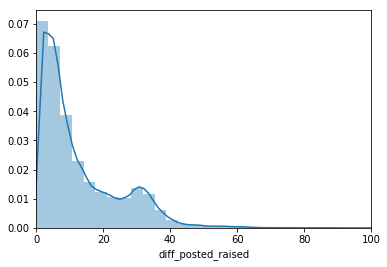

In [16]:
sns.distplot(df_clean_partner.diff_posted_raised)
plt.xlim(0, 100)

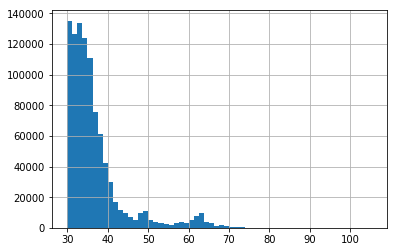

In [17]:
df_clean_partner["diff_posted_planned"].hist(bins=60);

In [18]:
df_clean.diff_posted_raised.describe()

count    1.355122e+06
mean     1.263507e+01
std      1.354196e+01
min      1.388889e-03
25%      3.552318e+00
50%      7.771412e+00
75%      1.849115e+01
max      5.337236e+02
Name: diff_posted_raised, dtype: float64

**Median days to get posted loan fully raised are 7.8 days.
Mean is 12.6 days.**

**Some (?) loans have a planned fund raising winder longer than 30 days. 
That explains why some loans take more than 30 days to get fully funded.**

In [20]:
df_clean_partner["diff_posted_planned"].describe()

count    970056.000000
mean         36.708125
std           7.435326
min          29.958380
25%          32.298854
50%          34.633970
75%          37.935061
max         105.285347
Name: diff_posted_planned, dtype: float64

In [21]:
df_clean_partner[df_clean_partner.diff_posted_raised > df_clean_partner.diff_posted_planned+2]

,LOAN_ID,LOAN_NAME,ORIGINAL_LANGUAGE,FUNDED_AMOUNT,LOAN_AMOUNT,STATUS,ACTIVITY_NAME,SECTOR_NAME,LOAN_USE,COUNTRY_CODE,COUNTRY_NAME,TOWN_NAME,CURRENCY_POLICY,CURRENCY_EXCHANGE_COVERAGE_RATE,CURRENCY,PARTNER_ID,POSTED_TIME,PLANNED_EXPIRATION_TIME,DISBURSE_TIME,RAISED_TIME,LENDER_TERM,NUM_LENDERS_TOTAL,BORROWER_NAMES,BORROWER_GENDERS,BORROWER_PICTURED,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL,diff_posted_planned,diff_posted_raised,GROUP
367846,807603,Anjelin's Group,English,1325.0,1325.0,funded,Agriculture,Agriculture,to purchase a solar light and gain access to c...,KE,Kenya,kakamega south,shared,0.1,KES,202.0,2014-11-28 08:54:50,2015-01-17 15:00:04,2015-02-01 08:00:00,2015-01-20 23:29:45,11.0,45,"Catherine, Anjeline, Henry, Aggrey, David, Jam...","female, female, male, male, female, male, fema...","true, true, true, true, true, true, true, true...",bullet,field_partner,50.253634,53.607581,1
897526,1204459,NaN,Spanish,1000.0,1000.0,funded,Personal Housing Expenses,Housing,buy the necessary construction materials.,SV,El Salvador,NaN,shared,0.1,USD,81.0,2016-12-15 17:29:55,2017-01-14 19:20:02,2016-11-30 08:00:00,2017-01-17 18:09:45,14.0,33,NaN,female,true,monthly,field_partner,30.076470,33.027662,0
1301169,792004,Miguel Emiro,Spanish,500.0,500.0,funded,Pigs,Agriculture,to make improvements to the pen where he keeps...,CO,Colombia,Sahagun,shared,0.1,COP,177.0,2014-10-30 21:25:30,2014-12-15 08:50:02,2014-09-30 07:00:00,2014-12-18 01:49:02,15.0,16,Miguel Emiro,male,true,bullet,field_partner,45.475370,48.183009,0


## Step.2 Factors affect the speed for a loan to get fully funded

(0, 55000)

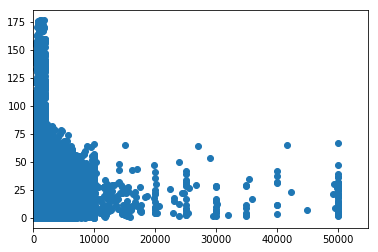

In [22]:
plt.scatter(df_clean_partner['LOAN_AMOUNT'],df_clean_partner['diff_posted_raised'])
plt.xlim(0,55000)

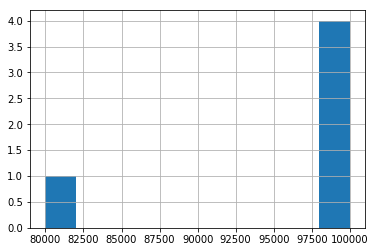

In [23]:
(df_clean_partner[(df_clean_partner.LOAN_AMOUNT)>60000]['LOAN_AMOUNT']).hist();

In [24]:
df_BKT1 = df_clean_partner[df_clean_partner.LOAN_AMOUNT <= 2000]
df_BKT2 = df_clean_partner[(df_clean_partner.LOAN_AMOUNT > 2000) & (df_clean_partner.LOAN_AMOUNT <= 10000)]
df_BKT3 = df_clean_partner[(df_clean_partner.LOAN_AMOUNT > 10000) & (df_clean_partner.LOAN_AMOUNT <= 50000)]
df_BKT4 = df_clean_partner[(df_clean_partner.LOAN_AMOUNT > 50000) & (df_clean_partner.LOAN_AMOUNT <= 500000)]

In [25]:
bins = list(range(0,2200,200))
df_BKT1['binned'] = pd.cut(df_BKT1['LOAN_AMOUNT'],bins)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [26]:
bins_post_plan = [30,35,40,60,80,106]
df_BKT1['bins_post_plan'] = pd.cut(df_BKT1['diff_posted_planned'],bins_post_plan)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [28]:
df_BKT1.head(2)

,LOAN_ID,LOAN_NAME,ORIGINAL_LANGUAGE,FUNDED_AMOUNT,LOAN_AMOUNT,STATUS,ACTIVITY_NAME,SECTOR_NAME,LOAN_USE,COUNTRY_CODE,COUNTRY_NAME,TOWN_NAME,CURRENCY_POLICY,CURRENCY_EXCHANGE_COVERAGE_RATE,CURRENCY,PARTNER_ID,POSTED_TIME,PLANNED_EXPIRATION_TIME,DISBURSE_TIME,RAISED_TIME,LENDER_TERM,NUM_LENDERS_TOTAL,BORROWER_NAMES,BORROWER_GENDERS,BORROWER_PICTURED,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL,diff_posted_planned,diff_posted_raised,GROUP,binned,bins_post_plan
0,657307,Aivy,English,125.0,125.0,funded,General Store,Retail,to buy additional inventories for her sari-sa...,PH,Philippines,Ozamiz - Ozamiz City,shared,0.1,PHP,126.0,2014-01-15 02:23:45,2014-02-14 03:30:06,2013-12-22 08:00:00,2014-01-15 04:48:22,7.0,3,Aivy,female,true,irregular,field_partner,30.046076,0.100428,0,"(0, 200]","(30, 35]"
1,657259,Idalia Marizza,Spanish,400.0,400.0,funded,Used Clothing,Clothing,"To buy American clothing such as blouses, shir...",HN,Honduras,"La Lopez, Choloma",shared,0.1,HNL,201.0,2014-01-14 20:23:20,2014-03-26 22:25:07,2013-12-20 08:00:00,2014-02-25 06:42:06,8.0,11,Idalia Marizza,female,true,monthly,field_partner,71.084572,41.429699,0,"(200, 400]","(60, 80]"


In [29]:
df_BKT1.groupby('binned').agg({'diff_posted_raised':"mean"})

,diff_posted_raised
binned,
"(0, 200]",6.018125
"(200, 400]",10.109037
"(400, 600]",13.119104
"(600, 800]",13.742476
"(800, 1000]",14.842584
"(1000, 1200]",15.897085
"(1200, 1400]",17.026248
"(1400, 1600]",18.627674
"(1600, 1800]",16.778657


In [30]:
df_b1_analysis = df_BKT1.groupby(['binned',"bins_post_plan"]).agg({'diff_posted_raised':"mean"}).unstack()
df_b1_analysis

diff_posted_raised                                            
bins_post_plan           (30, 35]   (35, 40]   (40, 60]   (60, 80]  (80, 106]
binned                                                                       
(0, 200]                 3.657483   8.444294  14.002704   8.880310  35.031930
(200, 400]               8.507232  13.119592  19.139422  13.381169  33.543791
(400, 600]              11.423039  16.601564  23.881644  20.623676  31.682284
(600, 800]              12.122588  17.709042  24.701080  25.443826  40.491914
(800, 1000]             13.443521  18.577126  26.040913  28.253062  40.621125
(1000, 1200]            14.349373  19.777488  26.811888  30.103130  37.986179
(1200, 1400]            13.804019  19.960297  26.006512  31.592258  45.134330
(1400, 1600]            14.972649  20.262593  27.411291  35.136455  39.924205
(1600, 1800]            13.669171  19.045713  25.198840  30.731547  43.355244
(1800, 2000]            14.371077  19.273687  26.150032  36.971894  41.481948

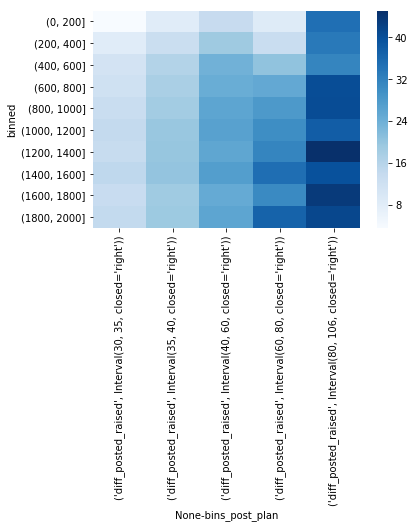

In [32]:
# corr = df[['LOAN_AMOUNT', 'LENDER_TERM', 'NUM_LENDERS_TOTAL', 'GROUP']].corr()
sns.heatmap(df_b1_analysis, 
            xticklabels=df_b1_analysis.columns.values,
            yticklabels=df_b1_analysis.index.values,
           cmap='Blues');

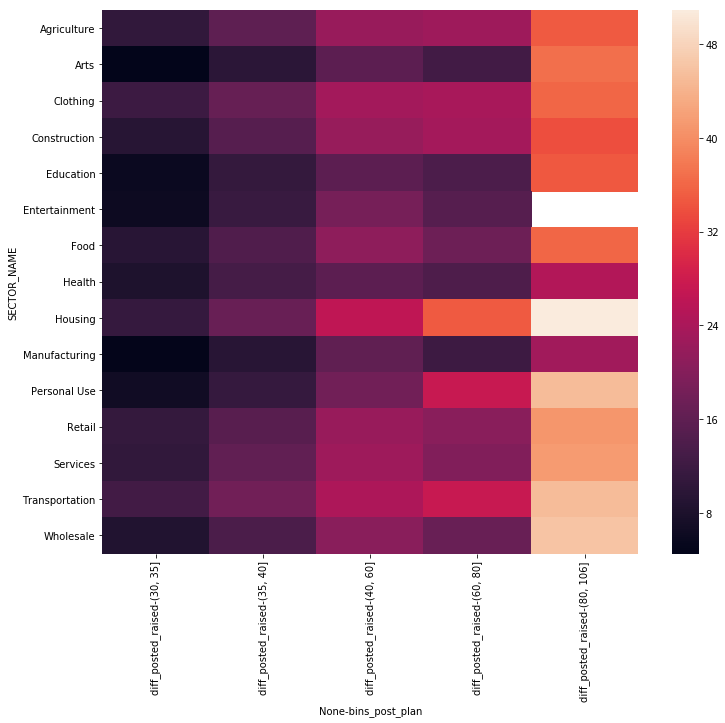

In [33]:
plt.figure(figsize=(12,10))
sns.heatmap(df_BKT1.groupby(['SECTOR_NAME','bins_post_plan']).agg({'diff_posted_raised':"mean"}).unstack());

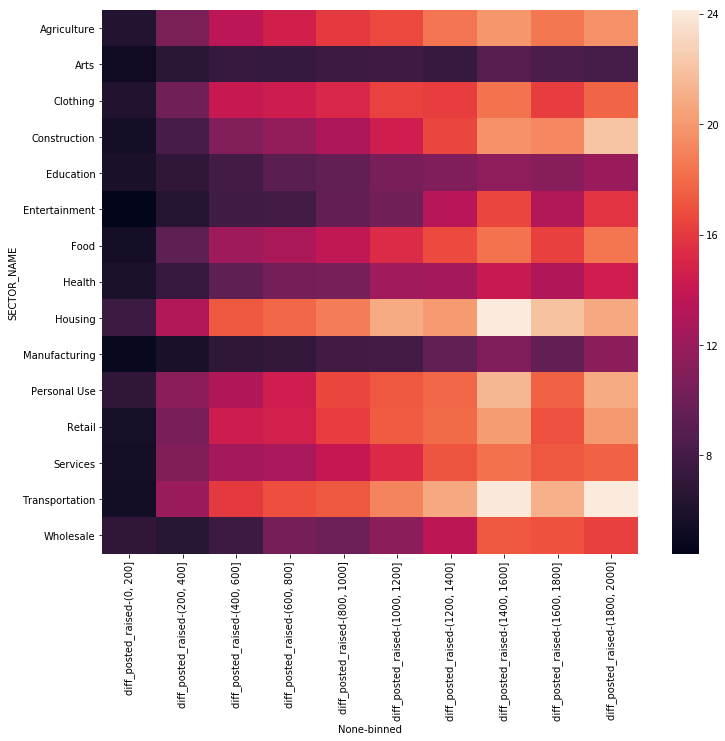

In [34]:
plt.figure(figsize=(12,10))
sns.heatmap(df_BKT1.groupby(['SECTOR_NAME','binned']).agg({'diff_posted_raised':"mean"}).unstack())

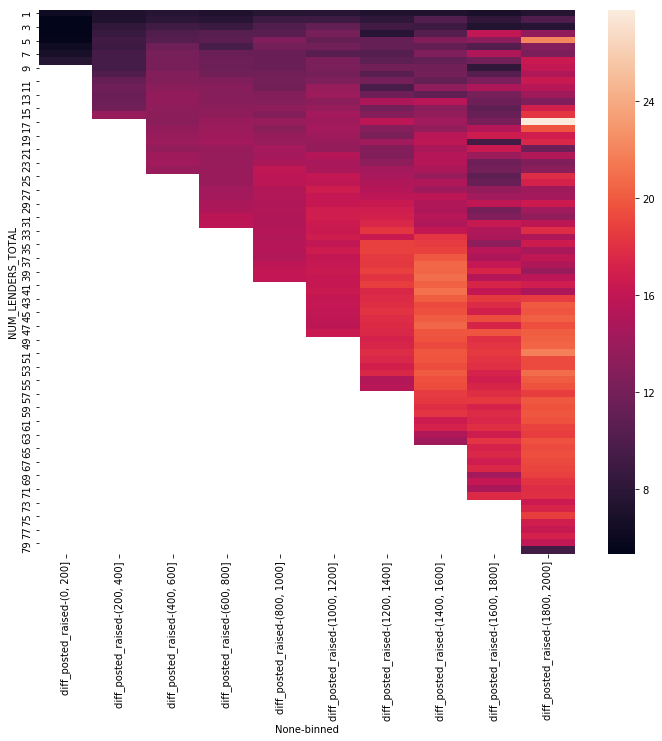

In [35]:
plt.figure(figsize=(12,10))
sns.heatmap(df_BKT1.groupby(['NUM_LENDERS_TOTAL','binned']).agg({'diff_posted_raised':"mean"}).unstack())

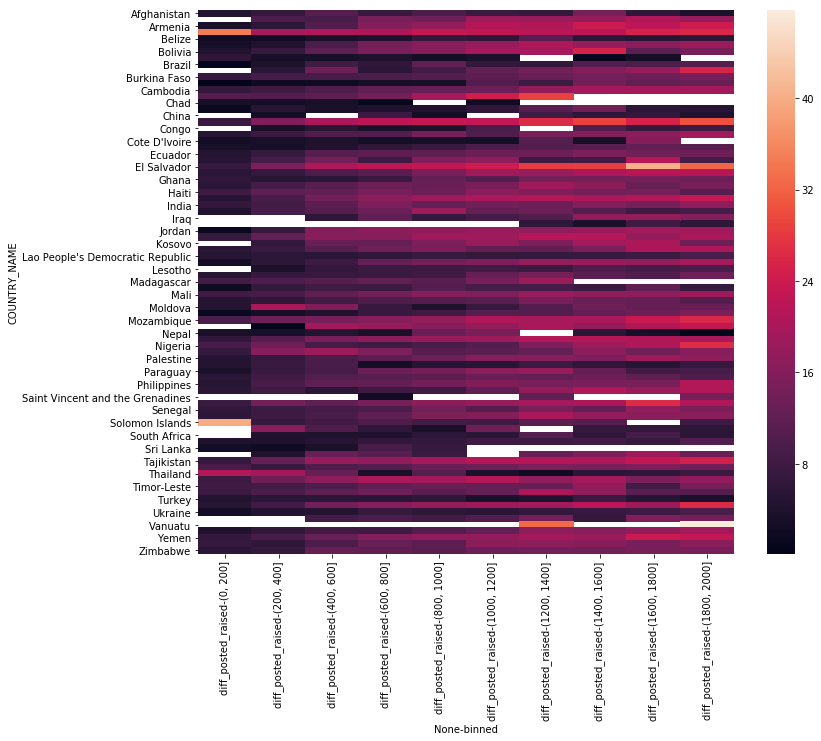

In [36]:
plt.figure(figsize=(12,10))
sns.heatmap(df_BKT1.groupby(['COUNTRY_NAME','binned']).agg({'diff_posted_raised':"mean"}).unstack());

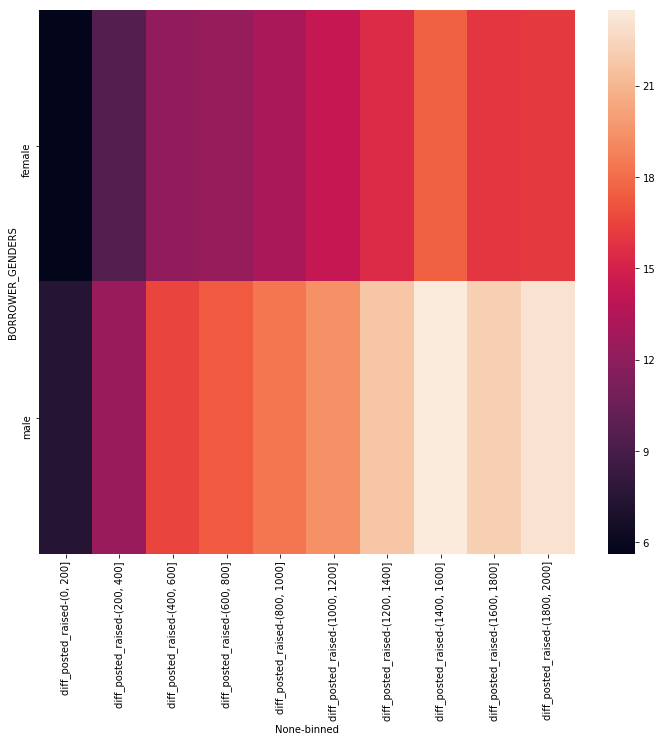

In [38]:
plt.figure(figsize=(12,10))
sns.heatmap(df_BKT1[df_BKT1['GROUP']!=True].groupby(['BORROWER_GENDERS','binned']).agg({'diff_posted_raised':"mean"}).unstack());

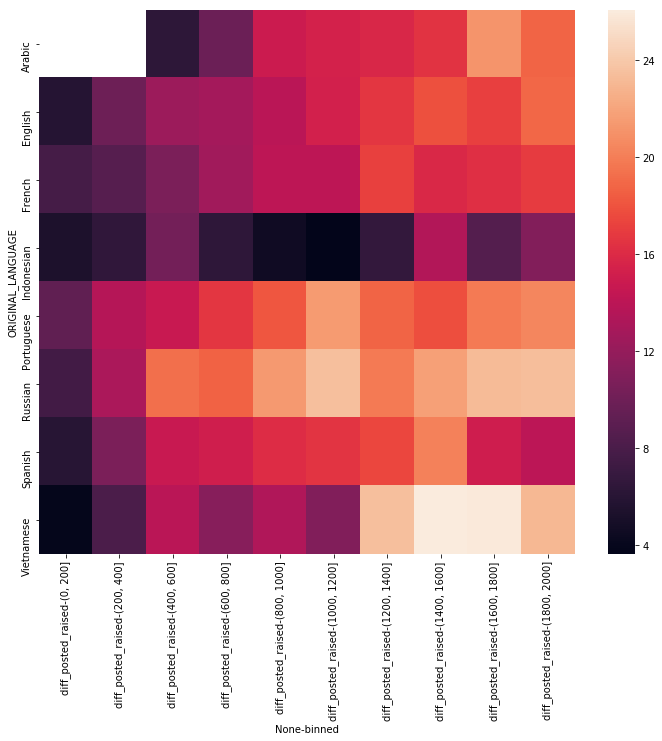

In [39]:
plt.figure(figsize=(12,10))
sns.heatmap(df_BKT1.groupby(['ORIGINAL_LANGUAGE','binned']).agg({'diff_posted_raised':"mean"}).unstack());

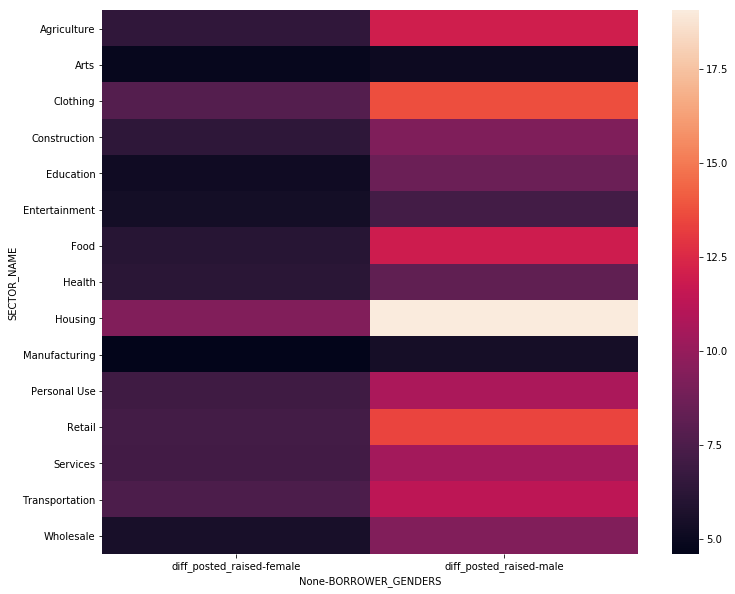

In [40]:
plt.figure(figsize=(12,10))
sns.heatmap(df_BKT1[df_BKT1['GROUP']!=True].groupby(['SECTOR_NAME','BORROWER_GENDERS']).agg({'diff_posted_raised':"median"}).unstack())

In [41]:
df_BKT1[df_BKT1['GROUP']!=True].groupby(['SECTOR_NAME','BORROWER_GENDERS']).agg({'diff_posted_raised':"median"}).unstack()

diff_posted_raised           
BORROWER_GENDERS             female       male
SECTOR_NAME                                   
Agriculture                6.447164  12.020775
Arts                       4.859282   5.062917
Clothing                   7.793675  13.737766
Construction               6.397130   9.249485
Education                  5.178426   8.592911
Entertainment              5.360498   7.180324
Food                       6.112049  11.900822
Health                     6.200642   8.166892
Housing                    9.293796  19.044861
Manufacturing              4.605446   5.450799
Personal Use               6.984051  10.703796
Retail                     7.195631  13.432240
Services                   7.115417  10.435932
Transportation             7.502928  11.364965
Wholesale                  5.545428   9.330972

In [42]:
# H0: mu_group - mu_individual = 0
# Ha: mu_group - mu_induvidual != 0

# alpha = 0.05

# T test
t, p = sts.ttest_ind(df_BKT1[df_BKT1['BORROWER_GENDERS']=='male']['diff_posted_raised'], df_BKT1[df_BKT1['BORROWER_GENDERS']=='female']['diff_posted_raised'], equal_var=False)

# p value
print("p-value: {:2.2f}".format(p))

p-value: 0.00


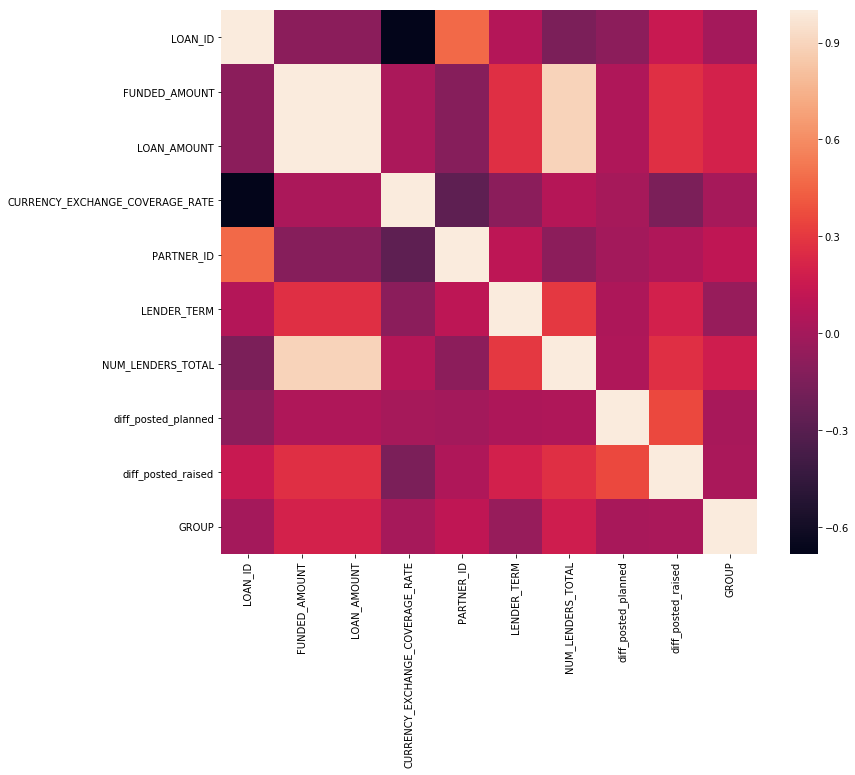

In [44]:
plt.figure(figsize=(12,10))
sns.heatmap(df_BKT1.corr());